1.15.0
Instructions for updating:
Use `tf.global_variables_initializer` instead.
(35102,)
Epoch  0  alpha  0.005  Perplexity train:  299.3300075705715  Perplexity valid:  261.0298581853716  Perplexity test:  300.06240192488184
Epoch  1  alpha  0.005  Perplexity train:  191.8861481699256  Perplexity valid:  227.09367259696802  Perplexity test:  260.2065539235814
Epoch  2  alpha  0.005  Perplexity train:  159.25103237951444  Perplexity valid:  213.998027325666  Perplexity test:  243.8861986150631
Epoch  3  alpha  0.005  Perplexity train:  138.38397560307246  Perplexity valid:  208.14756997811472  Perplexity test:  236.79697779983445
Epoch  4  alpha  0.005  Perplexity train:  122.87800521614783  Perplexity valid:  206.7502405731494  Perplexity test:  235.17490940244122
Epoch  5  alpha  0.005  Perplexity train:  110.60676511002141  Perplexity valid:  208.3879990220169  Perplexity test:  237.1856062209442
Epoch  6  alpha  0.005  Perplexity train:  100.49058381168952  Perplexity valid:  212.

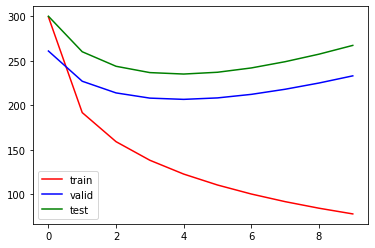

<Figure size 432x288 with 0 Axes>

In [1]:
import numpy as np
import warnings
import math
from tqdm import tqdm
import pickle

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    import tensorflow as tf
    print(tf.__version__)

def create_batches(corpus, n_batches):
    if len(corpus) % math.ceil(len(corpus)/n_batches) != 0:
      zeros = np.zeros(((math.ceil(len(corpus)/n_batches)) - (len(corpus) % (math.ceil(len(corpus)/n_batches)))))
      corpus = np.append(corpus, zeros, axis=0)
      
    batched_corpus = np.reshape(corpus, (n_batches, math.ceil(len(corpus)/n_batches)))
    
    return batched_corpus

def load_pickle(filename):
    loaded_content = pickle.load(open(filename, "rb"))
    return loaded_content


class Parameters():
    def __init__(self, vocab_size, n_train,window_size=5,n_nodes_hl=50,n_dimensions=60,alpha=0.02, n_batches=30,n_epochs=5,r=0.1):
        self.V = vocab_size
        self.window_size = window_size
        self.n_nodes_hl = n_nodes_hl
        self.n_dimensions = n_dimensions
        self.alpha = alpha
        self.n_batches = n_batches
        self.batch_size = math.ceil(n_train / self.n_batches)
        self.in_size = [self.n_batches, self.window_size * self.n_dimensions]  #no of batches = 668921
        self.in_size_bow = [self.n_batches, self.n_dimensions]
        self.out_size = [self.n_batches, self.V]
        self.n_epochs = n_epochs
        self.r = r


class BengioModel:
    def __init__(self, params):
        self.x = tf.compat.v1.placeholder(tf.int32, shape=[params.n_batches, params.window_size], name="x")
        self.y = tf.compat.v1.placeholder(tf.int32, shape=[params.n_batches], name="y")
        self.alpha = tf.compat.v1.placeholder(tf.float32, shape=[1], name="alpha")
        with tf.compat.v1.variable_scope("foo") as scope:
            self.C = tf.compat.v1.get_variable("C", [params.V, params.n_dimensions], tf.float32)
            self.W = tf.compat.v1.get_variable("W", [params.window_size * params.n_dimensions, params.V], tf.float32)
            self.W_bow = tf.compat.v1.get_variable("W_bow", [params.n_dimensions, params.V], tf.float32)
            self.H = tf.compat.v1.get_variable("H", [params.window_size * params.n_dimensions, params.n_nodes_hl], tf.float32)
            self.H_bow = tf.compat.v1.get_variable("H_bow", [params.n_dimensions, params.n_nodes_hl], tf.float32)
            self.d = tf.compat.v1.get_variable("d", [1, params.n_nodes_hl], tf.float32)
            self.U = tf.compat.v1.get_variable("U", [params.n_nodes_hl, params.V], tf.float32)
            self.b = tf.compat.v1.get_variable("b", [1, params.V], tf.float32)

    def forward(self, x):
        # y = b + Wx + U*tanh(d+ Hx)
        x_embedded = tf.reshape(tf.nn.embedding_lookup(self.C, x), params.in_size)
        a1 = tf.matmul(tf.tanh(tf.add(self.d, (tf.matmul(x_embedded, self.H)))), self.U)
        logits = tf.add(tf.add(tf.matmul(x_embedded, self.W), self.b), a1)
        return logits

    def forward_bow(self, x):
        x_embedded = tf.nn.embedding_lookup(self.C, x)
        x_embedded_bow = tf.math.reduce_sum(x_embedded,1,keepdims=True)
        a1 = tf.matmul(tf.tanh(tf.add(self.d, (tf.matmul(x_embedded_bow, self.H_bow)))), self.U)
        logits = tf.add(tf.add(tf.matmul(x_embedded_bow, self.W_bow), self.b), a1)
        return logits

    def compute_loss(self,logits,y,vocab_size):
      y_labels = tf.one_hot(y, vocab_size,name='y_label')
      self.loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_labels,logits=logits)

    def perform_optimization(self, alpha, loss):
      self.optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(loss)

def run_model(data_train,data_valid, data_test, model, params, running_mode):
  if running_mode == 'train':
    train_data = create_batches(data_train, params.n_batches)
    test_data = create_batches(data_test, params.n_batches)
    valid_data = create_batches(data_valid, params.n_batches)
    logits = model.forward(model.x)
    model.compute_loss(logits, model.y,params.V)
    model.perform_optimization(params.alpha, model.loss)
    
    perplexity = [[],[],[]]
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        print(train_data[1].shape)
        for epoch in range(params.n_epochs):
            losses = [[],[],[]] #cross entropy loss is negative log prob
            #for i in range(params.batch_size - params.window_size): 
            for i in range(train_data.shape[1] - params.window_size): 
                x = train_data[:, i: i+params.window_size]
                y = train_data[:, i + params.window_size]            
                _, c = sess.run([model.optimizer, model.loss], feed_dict={model.x: x, model.y: y})
                losses[0].append(c)
            perplexity[0].append(math.exp(np.mean(losses[0])))

            for i in range(valid_data.shape[1] - params.window_size): 
                x = valid_data[:, i: i+params.window_size]
                y = valid_data[:, i + params.window_size]            
                c = sess.run([model.loss], feed_dict={model.x: x, model.y: y})
                losses[1].append(c)
            perplexity[1].append(math.exp(np.mean(losses[1])))

            #for i in range(params.batch_size - params.window_size):  
            for i in range(test_data.shape[1] - params.window_size): 
                x = test_data[:, i: i+params.window_size]
                y = test_data[:, i + params.window_size]            
                c = sess.run([model.loss], feed_dict={model.x: x, model.y: y})
                losses[2].append(c)
            perplexity[2].append(math.exp(np.mean(losses[2])))

            print("Epoch ", epoch, 
                  ' alpha ', params.alpha, 
                  ' Perplexity train: ', perplexity[0][-1],
                  ' Perplexity valid: ', perplexity[1][-1],
                  ' Perplexity test: ' , perplexity[2][-1])
            
    return perplexity

def plot_perplexity(perplexity_list):
    import matplotlib.pyplot as plt
    colors = ['r','b','g']
    labels = ['train', 'valid', 'test']
    for i, perp in enumerate(perplexity_list):
      epoch_nums = list(range(len(perplexity_list[0])))
      plt.plot(epoch_nums, perp, color=colors[i], label=labels[i])
      plt.legend()
    plt.show()
    plt.savefig('brown_benchmark.jpg')

if __name__ == "__main__":
    vocab_dict = load_pickle("vocab_dict_brown.pkl")
    train_data = load_pickle("train_step3.pkl")
    valid_data = load_pickle('valid_step3.pkl')
    test_data = load_pickle('test_step3.pkl')
    # train_data = train_data[:2000]
    # valid_data = valid_data[:2000]
    # test_data = test_data[:2000]
    params = Parameters(vocab_size=len(vocab_dict), n_train=len(train_data),n_epochs=10, alpha=0.005)
    bengio_model = BengioModel(params)
    perplexity_list = run_model(train_data, valid_data,test_data, bengio_model, params, 'train')
    pickle.dump(perplexity_list, open('perplexity.pkl','wb'))
    plot_perplexity(perplexity_list)
    
    
    